## Unsupervised Capstone Rough Draft
This is a rough draft of my write up for the unit 4 capstone project. The data consists of excerpts, mostly chapters, of science fiction novels, novellas and short stories by the following authors:
 - Isaac Asimov
 - Kurt Vonnegut
 - H.G. Wells
 - Ray Bradbury
 - Philip K. Dick
 - Frank Patrick Herbert
 - Frederik Pohl
 - Mack Reynolds
 - Carey Rockwell
 - Jules Verne
<br><br>

The works are all eBooks provided by Project Gutenburg, and I must include the following text as is required by their license:<br><br>
>This eBook is for the use of anyone anywhere in the United States and
>most other parts of the world at no cost and with almost no
>restrictions whatsoever. You may copy it, give it away or re-use it
>under the terms of the Project Gutenberg License included with this
>eBook or online at www.gutenberg.org. If you are not located in the
>United States, you'll have to check the laws of the country where you
>are located before using this ebook.
 
<br><br>
The goal of this project is to use clustering to build features on the dataset. I use these clusters to build a predictive model that can predict authors from the texts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.colors import Colormap
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib import cm
from cycler import cycler
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import AffinityPropagation
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import gc
%matplotlib inline

## The Data
This dataset contains 100 samples from the ten authors listed above. The excerpts all come from one of two works by each of the authors. They vary in length from over 600 words to under 1400 words.

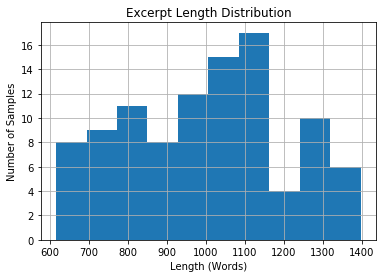

In [2]:
df = pd.read_csv('docs.csv').sample(frac=1, random_state=0) #load dataset and shuffle rows
df.index = range(0, 100) #reindex
df.length.hist();
plt.title('Excerpt Length Distribution');
plt.xlabel('Length (Words)');
plt.ylabel('Number of Samples');
plt.show();

Each author has roughly ten examples, except for Vonnegut. Because he only has two short stories under the open distribution license, I could only grab six excerpts long enough to compare to the others.

In [3]:
df.author.value_counts()

wells       11
pohl        11
asimov      11
verne       11
bradbury    10
reynolds    10
dick        10
rockwell    10
herbert     10
vonnegut     6
Name: author, dtype: int64

This smaller sample size may have something to do with a problem I have classifying his work later on. <br> The excerpts come with some tags; the title of the source text, the author last name, the date of publication, whether the text is fiction (two non-fiction works are <I>Worlds within Worlds</I> by Asimov and <I>Discovery of the Future</I> by H.G. Wells, both of which discuss the technological implications of then-current scientific developments)

In [4]:
df.head() #A peek at the data

,text,title,author,date,fiction,length
0,"\n He fixed things--clocks, refrigerators, ...",variableman,dick,1953,1,1106
1,\nGramps missed none of the high drama he had ...,trip_up_yonder,vonnegut,1953,1,880
2,\nThe swaying had come to a halt and it was da...,youth,asimov,1952,1,1155
3,\nThey gave him a gold watch. It was meant to ...,spaceman_spree,reynolds,1963,1,758
4,"\n""Conseil,"" I called in an impatient voice.\n...",20000leagues,verne,1870,1,801


# Holdout Group
I reserve 25% of the data as a holdout group. 

In [5]:
#Reserve holdout group
train = df.loc[:74].copy() #train group
test = df.loc[75:].copy() #holdout group
train.author.value_counts()

asimov      10
wells        9
reynolds     9
bradbury     8
pohl         8
dick         8
verne        8
herbert      7
rockwell     5
vonnegut     3
Name: author, dtype: int64

Note that the training group includes only three samples for Kurt Vonnegut.

## Parsing and LSA

In [6]:
def get_lemmas(document):
    """takes raw spacy parse and returns only
    word lemmas, in or out of vocab.
    """
    result = ''
    for token in document:
        if not token.is_space and not token.is_punct and not (token.lemma_ == '-PRON-'):
            result += token.lemma_ + ' '
        elif token.lemma_ == '-PRON-':
            result += token.orth_ + ' '
    return result

In [7]:
prs = spacy.load('en')
train['raw_parse'] = train.text.apply(prs)
train['lemmas'] = train.raw_parse.apply(get_lemmas)
vec = TfidfVectorizer(stop_words='english', min_df=2, max_df=.99, ngram_range=(1, 3))
svd = TruncatedSVD(n_components=74, random_state=0, algorithm='arpack')
norm = Normalizer(copy=False)
lsa = make_pipeline(svd, norm)
raw_vec_train = vec.fit_transform(train.lemmas)
train_mat = lsa.fit_transform(raw_vec_train)

## Clustering with Affinity Propagation
Affinity Propagation does a great job of clustering the documents by their source texts. I used K-Means, Mean Shift, and Spectral Clustering as well, but Affinity Propagation groups the samples by authors almost perfectly. It actually tends to group the samples by source text, which works well enough for the task of classifying texts by authors. I used the Adjusted Rand Index to find the best clustering technique.

In [8]:
#Encode the authors and the source texts for cluster evaluation
author_encoding = {}
code = iter(range(0, len(df.author.unique())))
for auth in df.author.unique():
    author_encoding[auth] = next(code)
    
train['author_code'] = train.author.apply(lambda x: author_encoding[x])
test['author_code'] = test.author.apply(lambda x: author_encoding[x])

title_encoding = {}
code = iter(range(0, len(df.title.unique())))
for tit in df.title.unique():
    title_encoding[tit] = next(code)
    
train['title_code'] = train.title.apply(lambda x: title_encoding[x])
test['title_code'] = test.title.apply(lambda x: title_encoding[x])

In [9]:
trans = vec.fit_transform(train.lemmas)
train_mat = lsa.fit_transform(trans)
ap = AffinityPropagation()
np.unique(ap.fit_predict(train_mat))
labels = train.title_code #Setting the labels to the text titles to show clustering around source texts.
print('number of clusters: ', len(ap.cluster_centers_))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, ap.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, ap.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, ap.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, ap.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_mat, ap.labels_, sample_size=-1))

number of clusters:  19
Homogeneity: 0.976
Completeness: 0.981
V-measure: 0.978
Adjusted Rand-Index: 0.927
Silhouette Coefficient: 0.179


## Characterizing the Clusters
While homogeneity and completeness of the clusters against source texts is very high, the cluster groupings in terms of source text is not perfect. This is made clear by the fact that there are 19 clusters and 20 source texts. I define each cluster by the source texts and authors that appear in each.

In [10]:
train['ap_cluster'] = ap.predict(train_mat) #record cluster assignments for training group
clusters = {}
for clust in train.ap_cluster.unique():
    clusters[clust] = (
        list(train[train.ap_cluster==clust].author.unique()), 
        list(train[train.ap_cluster==clust].title.unique()),
    )

authors = {}
for auth in train.author.unique():
    authors[auth] = train[train.author==auth].ap_cluster.unique()
    
for clust in range(0, len(clusters)):
    print('cluster ', clust, 'authors: ', clusters[clust][0], 'source texts: ', clusters[clust][1])

cluster  0 authors:  ['dick'] source texts:  ['variableman']
cluster  1 authors:  ['reynolds'] source texts:  ['spaceman_spree']
cluster  2 authors:  ['reynolds'] source texts:  ['off_course']
cluster  3 authors:  ['asimov'] source texts:  ['nuclear_energy_3']
cluster  4 authors:  ['dick'] source texts:  ['mrspaceship']
cluster  5 authors:  ['herbert'] source texts:  ['haystack']
cluster  6 authors:  ['asimov'] source texts:  ['youth']
cluster  7 authors:  ['rockwell'] source texts:  ['space_pirates', 'venus_revolt']
cluster  8 authors:  ['verne'] source texts:  ['20000leagues']
cluster  9 authors:  ['pohl'] source texts:  ['skysearch']
cluster  10 authors:  ['bradbury'] source texts:  ['futuria']
cluster  11 authors:  ['bradbury'] source texts:  ['futuria']
cluster  12 authors:  ['herbert'] source texts:  ['old_rambling_house']
cluster  13 authors:  ['wells'] source texts:  ['discovery_future']
cluster  14 authors:  ['bradbury'] source texts:  ['a_little_journey']
cluster  15 authors:

Every cluster belongs to just one author. Clusters 7 and 16 include chapters from different source texts by the same author, and clusters 10 and 11 both include chapters from the same source text, Futuria by Bradbury.<br><br>
## Visualizing the Clusters
I use the t-SNE algorithm to visualize the clusters in two dimensions. In the following plot, authors are represented by colors and clusters are represented by shapes. Most authors have two clusters but some have only one while others have three. Thus, I've given an ordered set of shapes to represent the clusters. The order doesn't matter except to denote the number of clusters an author has.

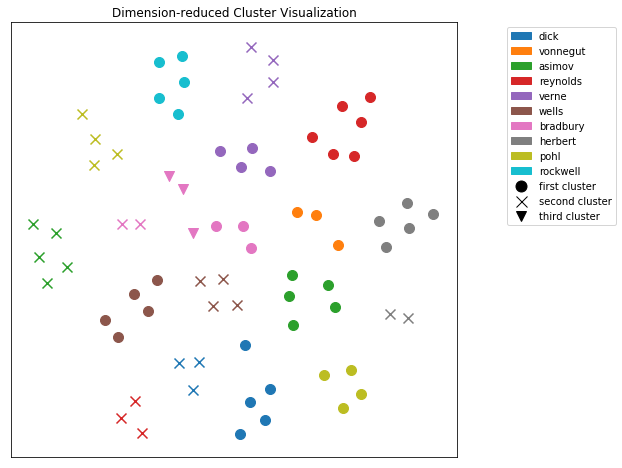

In [11]:
tsne = TSNE(
    n_components=2, 
    init='pca', 
    random_state=0, 
    method='exact', 
    early_exaggeration=200, 
    learning_rate=200,
    n_iter=10000
)
ts = tsne.fit_transform(train_mat)
fig, ax = plt.subplots(figsize=(8, 8));
train['ts1'] = ts[:,0]
train['ts2'] = ts[:,1]
handles = []
color = 0
for auth in authors:
    dframe = train[train.author==auth]
    col = cm.tab10(color)
    handles.append(mpatches.Patch(color=col, label=auth));
    color += 1
    styles = iter(['o', 'x', 'v'])
    for clust in dframe.ap_cluster.unique():
        plt.scatter(
            dframe[dframe.ap_cluster==clust].ts1, 
            dframe[dframe.ap_cluster==clust].ts2, 
            color=col, 
            marker=next(styles),
            s=100
        )
handles.append(mlines.Line2D([], [], color='black', marker='o', linewidth=0, label='first cluster', markersize=11))
handles.append(mlines.Line2D([], [], color='black', marker='x', linewidth=0, label='second cluster', markersize=11))
handles.append(mlines.Line2D([], [], color='black', marker='v', linewidth=0, label='third cluster', markersize=10))
plt.legend(handles=(handles), bbox_to_anchor=(1.1, 1));
plt.title('Dimension-reduced Cluster Visualization');
ax.set_xticks([]);
ax.set_yticks([]);
plt.show();

While most authors' clusters are located close to each other, some are seperated by a number of other samples. Asimov, for example, has one cluster on the far left and another to the lower right side of the center of the plot. This specific case might be explained by the fact that one of Asimov's works is non-fiction, and the other is fiction. Take a look at the closeness of the nonfiction clusters on the t-SNE reduction.

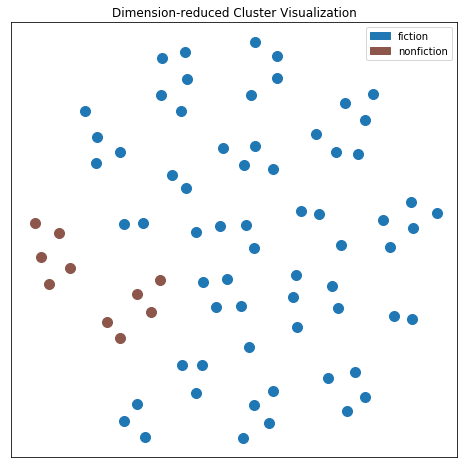

In [12]:
fig, ax = plt.subplots(figsize=(8, 8));
c1 = cm.tab10(0)
c2 = cm.tab10(5)
colors = iter([c1, c2])
for genre in train.fiction.unique():
    dframe = train[train.fiction==genre]
    plt.scatter(dframe.ts1, dframe.ts2, c=next(colors), s=100);
        
handles = []
handles.append(mpatches.Patch(color=cm.tab10(0), label='fiction'))
handles.append(mpatches.Patch(color=cm.tab10(5), label='nonfiction'))
plt.title('Dimension-reduced Cluster Visualization');
plt.legend(handles=handles);
ax.set_xticks([]);
ax.set_yticks([]);
plt.show();

## Cluster Stability
To investigate the stability of these clusters, I use the same parsing and LSA process to assign clusters to the holdout group samples.

In [13]:
#Process text in holdout group
test['raw_parse'] = test.text.apply(prs)
test['lemmas'] = test.raw_parse.apply(get_lemmas)
trans = vec.transform(test.lemmas)
test_mat = lsa.transform(trans)

In [14]:
test['ap_cluster'] = ap.predict(test_mat) #get assignments for holdout group
train['is_holdout'] = 0
test['is_holdout'] = 1
df = pd.concat([train, test], axis=0)   #Add cluster assignments to original dataframe.
all_pc = np.concatenate([train_mat, test_mat], axis=0) #Concatenate LSA features from training and holdout groups.

Let's see where the holdout samples land compared to the others

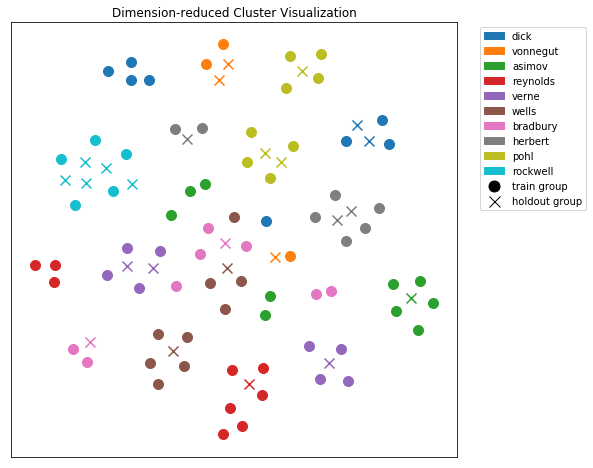

In [15]:
ts = tsne.fit_transform(all_pc)
fig, ax = plt.subplots(figsize=(8, 8));
df['ts1'] = ts[:,0]
df['ts2'] = ts[:,1]
handles = []
color = 0
for auth in authors:
    dframe = df[df.author==auth]
    col = cm.tab10(color)
    handles.append(mpatches.Patch(color=col, label=auth));
    color += 1
    styles = iter(['o', 'x', 'v'])
    for group in dframe.is_holdout.unique():
        plt.scatter(
            dframe[dframe.is_holdout==group].ts1, 
            dframe[dframe.is_holdout==group].ts2, 
            color=col, 
            marker=next(styles),
            s=100
        )
handles.append(mlines.Line2D([], [], color='black', marker='o', linewidth=0, label='train group', markersize=11))
handles.append(mlines.Line2D([], [], color='black', marker='x', linewidth=0, label='holdout group', markersize=11))
plt.legend(handles=(handles), bbox_to_anchor=(1.3, 1));
plt.title('Dimension-reduced Cluster Visualization');
ax.set_xticks([]);
ax.set_yticks([]);
plt.show();

I check to see if the holdout group clustering assignments deviate from our previous cluster definition.

In [16]:
deviant_assignments = []
for i in test.index:
    row = test.loc[i]
    cluster = clusters[row.ap_cluster]
    if row.author not in cluster[0]:
        print('devation: author {} assigned to cluster belonging to {}'.format(row.author, cluster[0][0]))
        print('deviation occured at index: ', i)
        deviant_assignments.append(i)
    if row.title not in cluster[1]:
        print('devation: title {} assigned to cluster belonging to {}'.format(row.title, cluster[1]))
        print('deviation occured at index: ', i)
        deviant_assignments.append(i)
        
deviant_assignments = list(set(deviant_assignments))

devation: author vonnegut assigned to cluster belonging to wells
deviation occured at index:  93
devation: title 2BR02B assigned to cluster belonging to ['moon_men']
deviation occured at index:  93


In [17]:
for i in deviant_assignments:
    print(test.loc[i])

text           \nEverything was perfectly swell.\n\nThere wer...
title                                                     2BR02B
author                                                  vonnegut
date                                                        1962
fiction                                                        1
length                                                      1152
author_code                                                    1
title_code                                                    19
raw_parse      (\n, Everything, was, perfectly, swell, ., \n\...
lemmas         everything be perfectly swell there be no pris...
ap_cluster                                                    18
is_holdout                                                     1
Name: 93, dtype: object


The holdout group gives only one deviation from the training group clustering. It assigns a chapter from "2BR02B" (1962) by Vonnegut to "The First Men in the Moon" (1901) by H.G. Wells. These two works are notably far apart in both time and topic. This may be the result of there being few examples for Vonnegut in the training set.

In [18]:
#Take a look at the text of the misassigned chapter.
test.loc[deviant_assignments[0]].raw_parse


Everything was perfectly swell.

There were no prisons, no slums, no insane asylums, no cripples, no
poverty, no wars.

All diseases were conquered. So was old age.

Death, barring accidents, was an adventure for volunteers.

The population of the United States was stabilized at forty-million
souls.

One bright morning in the Chicago Lying-in Hospital, a man named Edward
K. Wehling, Jr., waited for his wife to give birth. He was the only man
waiting. Not many people were born a day any more.

Wehling was fifty-six, a mere stripling in a population whose average
age was one hundred and twenty-nine.

X-rays had revealed that his wife was going to have triplets. The
children would be his first.

Young Wehling was hunched in his chair, his head in his hand. He was so
rumpled, so still and colorless as to be virtually invisible. His
camouflage was perfect, since the waiting room had a disorderly and
demoralized air, too. Chairs and ashtrays had been moved away from the
walls. The floor was